In [1]:
import numpy as np
import pandas as pd
from torch import nn

import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F

import re
import string
from collections import Counter
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

import pandas as pd
import numpy as np
import bz2
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
device = "cuda:0"

In [3]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [6]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

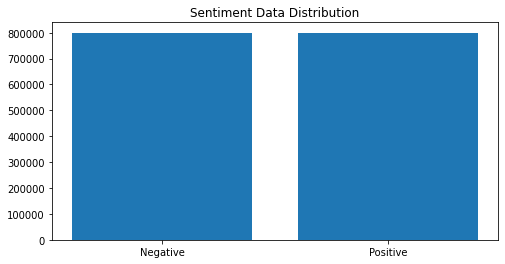

In [7]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [8]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment,text
314641,Negative,considering changing wedding dress to somethin...
75076,Negative,ahh my spanish teacher just sent me a correcte...
123997,Negative,Reason #107 why i hate sleeping (or trying to ...
928060,Positive,And she said
795593,Negative,I hate 7am conference calls
1079648,Positive,@Hameed_Hemmat Yes they r. Cuz wants Cavs to ...
86970,Negative,@ZRHERO Yeah and yeah. But i cant go on it atm...
1477180,Positive,"Time to sleep! See you all tommorow, have a go..."
702223,Negative,4 more hours of work
135315,Negative,@Alicia_C78 I know! Ugh! I still need to go bu...


In [9]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [10]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [11]:
df.text = df.text.apply(lambda x: preprocess(x))

## Train and Test Split

In [12]:
TRAIN_SIZE = 0.8 
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 10
LR = 1e-3
BATCH_SIZE = 50
EPOCHS = 10

In [13]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [14]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


In [15]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

print(type(x_train))
print(type(x_test))

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [16]:
labels = train_data.sentiment.unique().tolist()

In [17]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last = True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, drop_last = True)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [18]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
class SentimentNet(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(drop_prob)
        self.embedding_dim = embedding_dim
        self.sigmoid = nn.Sigmoid()
        
        
        self.encoder = nn.Embedding(vocab_size, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim, drop_prob)
        encoder_layer = nn.TransformerEncoderLayer(embedding_dim, 2, hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        

        self.fc = nn.Linear(embedding_dim * 30 , 1)

    
    def forward(self, src):
        src = self.encoder(src) * math.sqrt(self.embedding_dim)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output.view(output.size(0), -1)
        output = self.sigmoid(self.fc(output))
        return output

In [19]:
def model_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [20]:
import math

output_size = 1
embedding_dim = 128
hidden_dim = 4
n_layers = 1

model = SentimentNet(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)
print(model_params(model))
lr=0.01
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

37265157


In [21]:
epochs = 3
counter = 0
print_every = 500
clip = 5
valid_loss_min = np.Inf

model.train()
for i in range(epochs):
    
    for inputs, labels in train_loader:
        counter += 1
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output = model(inputs.long())
        
        loss = criterion(output, labels.float())
        
        
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            val_losses = []
            model.eval()
            for inp, lab in test_loader:
                inp, lab = inp.to(device), lab.to(device)
                out = model(inp.long())
                val_loss = criterion(out, lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

Epoch: 1/3... Step: 500... Loss: 0.680618... Val Loss: 0.711746
Validation loss decreased (inf --> 0.711746).  Saving model ...
Epoch: 1/3... Step: 1000... Loss: 0.691034... Val Loss: 0.695706
Validation loss decreased (0.711746 --> 0.695706).  Saving model ...
Epoch: 1/3... Step: 1500... Loss: 0.720864... Val Loss: 0.694203
Validation loss decreased (0.695706 --> 0.694203).  Saving model ...
Epoch: 1/3... Step: 2000... Loss: 0.684744... Val Loss: 0.692065
Validation loss decreased (0.694203 --> 0.692065).  Saving model ...
Epoch: 1/3... Step: 2500... Loss: 0.690393... Val Loss: 0.715199
Epoch: 1/3... Step: 3000... Loss: 0.702488... Val Loss: 0.691150
Validation loss decreased (0.692065 --> 0.691150).  Saving model ...
Epoch: 1/3... Step: 3500... Loss: 0.697118... Val Loss: 0.691071
Validation loss decreased (0.691150 --> 0.691071).  Saving model ...
Epoch: 1/3... Step: 4000... Loss: 0.681517... Val Loss: 0.694993
Epoch: 1/3... Step: 4500... Loss: 0.713281... Val Loss: 0.695210
Epoch: 

In [22]:
sentence = "I love you"
trial = torch.tensor(pad_sequences(tokenizer.texts_to_sequences([sentence]), maxlen = MAX_SEQUENCE_LENGTH)).long().to(device)

model(trial)

tensor([[0.6064]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [23]:
import torch.onnx
torch.onnx.export(model,               # model being run
                  trial,                  # model input (or a tuple for multiple inputs)
                  "transformer-imdb.onnx", opset_version = 11)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  app.launch_new_instance()
